*Group information*

| Surname     | First name |  BSE email     |
| ----------- | ---------- |  ------------- |
| Lisboa |  Vicente | vicente.lisboa@bse.eu   |
| Santos |  Lucas | lucas.santos@bse.eu   |
| Thomas |  Davis     | davis.thomas@bse.eu|

## Import libraries

In [37]:
import pandas as pd
import numpy as np
import pickle
import finEC.datapreproc as dpp
#import datapreproc as dpp

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  GridSearchCV, HalvingGridSearchCV, train_test_split
from xgboost import XGBRegressor

import xgboost as xgb

import warnings
from sklearn.exceptions import DataConversionWarning
import shap
import lime
import lime.lime_tabular


warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("default", category=DataConversionWarning)

## Import data

In [38]:
# loading data

df=pd.read_csv("../data/stock_prices_yahoo_2.csv",parse_dates=["Date"])

# %%
#ec = pd.read_pickle("../data/Sentiment_Market_Pharma/earnings_call_top10_ph.pickle")
ec=pickle.load(open("../data/Sentiment_Market_Pharma/earnings_call_top10_ph.pickle", "rb"))
ec=ec.reset_index()
events=ec[['symbol','date','quarter','year']]
events['date']=pd.to_datetime(events.date)
events.sort_values(['symbol','date'],inplace=True)

# %%
sp500=pd.read_csv("../data/SP500HistoricalData.csv",parse_dates=['Date'],thousands=',', decimal='.')
sp500latest=pd.read_csv("../data/HistoricalData_1686903580615.csv",parse_dates=['Date'],thousands=',', decimal='.')
sp500=pd.merge(sp500,sp500latest,how="outer",on="Date")

# %%
sp500=sp500[['Date','Price','Close/Last']]
sp500['Price'].fillna(sp500['Close/Last'], inplace=True)
sp500.drop(columns=['Close/Last'],inplace=True)
#rename the columns
sp500.columns=['Date','SP500']
sp500['Date']=pd.to_datetime(sp500.Date)
sp500.sort_values('Date',inplace=True)
sp500['pct_change_sp500'] = sp500['SP500'].pct_change()


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Preprocessing

In [39]:
df1=df.merge(sp500,how="left",on="Date")
df1.info()
df1.Date.min(),df1.Date.max()
df1 = df1.sort_values(['Ticker', 'Date'])
df1['pct_change_close'] = df1.groupby('Ticker')['Close'].pct_change()

pd.options.mode.chained_assignment = None  # default='warn'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44096 entries, 0 to 44095
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        44096 non-null  int64         
 1   index             44096 non-null  int64         
 2   Date              44096 non-null  datetime64[ns]
 3   Open              44096 non-null  float64       
 4   High              44096 non-null  float64       
 5   Low               44096 non-null  float64       
 6   Close             44096 non-null  float64       
 7   Adj Close         44096 non-null  float64       
 8   Volume            44096 non-null  int64         
 9   Ticker            44096 non-null  object        
 10  SP500             44096 non-null  float64       
 11  pct_change_sp500  44096 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 4.4+ MB


In [40]:
events['Beta'] = 0
events['ret_stock'] = 0
events['ret_sp500'] = 0

In [41]:
# selecting the row
events['Beta'] = 0

info = events.loc[15]
# PFE, 2011-05-03
specific_date = info.date

start_date = specific_date - datetime.timedelta(days=80)

market_variance = df1[(df1['Ticker'] == info.symbol) & (df1['Date'] >= start_date) & (df1['Date'] <= specific_date)]['pct_change_sp500'].var()

covariance = df1[(df1['Ticker'] == info.symbol) & (df1['Date'] >= start_date) & (df1['Date'] <= specific_date)]['pct_change_close'].cov(
    df1[(df1['Ticker'] == info.symbol) & (df1['Date'] >= start_date) & (df1['Date'] <= specific_date)]['pct_change_sp500']
)

beta = covariance / market_variance
beta

0.7176099443606413

In [42]:
for i, row in events.iterrows():
    specific_date = row['date']
    start_date = specific_date - datetime.timedelta(days=720)
    
    try:
        market_data = df1[(df1['Ticker'] == row['symbol']) & (df1['Date'] >= start_date) & (df1['Date'] <= specific_date)]
        market_variance = market_data['pct_change_sp500'].var()
        covariance = market_data['pct_change_close'].cov(market_data['pct_change_sp500'])
        beta = covariance / market_variance
        events.loc[i, 'Beta'] = beta
    except:
        events.loc[i, 'Beta'] = 0



In [43]:
# calculando o retorno acumulado

info = events.loc[15]
# PFE, 2011-05-03

specific_date = info.date + datetime.timedelta(days=2) 
end_date = specific_date + datetime.timedelta(days=30) 

market_data = df1[(df1['Ticker'] == row['symbol']) & (df1['Date'] <= end_date) & (df1['Date'] >= specific_date)]

market_data['1+ret'] = market_data['pct_change_close'] + 1
market_data.head()

ret_stock = market_data['1+ret'].cumprod()
        
# market_data['1+ret_sp'] = market_data['pct_change_sp500'] + 1
# ret_sp500 = market_data['1+ret_sp'].cumprod()[-1] - 1
        
print(ret_stock)
# print(ret_sp500)


41079    1.002565
41080    0.992306
41081    0.987818
41082    1.006198
41083    1.000000
41084    1.023509
41085    1.016029
41086    0.999573
41087    0.979910
41088    1.014960
41089    1.004702
41090    0.992306
41091    0.969010
41092    0.961744
41093    0.973071
41094    0.982689
41095    0.988459
41096    1.002992
41097    0.959179
41098    0.976491
41099    0.964736
Name: 1+ret, dtype: float64


In [44]:
for i, row in events.iterrows():
    specific_date = row['date'] + datetime.timedelta(days=2) 
    end_date = specific_date + datetime.timedelta(days=30) 
    
    try:
        market_data = df1[(df1['Ticker'] == row['symbol']) & (df1['Date'] <= end_date) & (df1['Date'] >= specific_date)]
        market_data['1+ret'] = market_data['pct_change_close'] + 1
        ret_stock = market_data['1+ret'].cumprod().iat[-1] - 1
        
        market_data['1+ret_sp'] = market_data['pct_change_sp500'] + 1
        ret_sp500 = market_data['1+ret_sp'].cumprod().iat[-1] - 1
        
        events.loc[i, 'ret_stock'] = ret_stock
        events.loc[i, 'ret_sp500'] = ret_sp500
    except:
        events.loc[i, 'ret_stock'] = 0
        events.loc[i, 'ret_sp500'] = 0


In [45]:
events['CAR2'] = events['ret_stock'] - (events['Beta'] * events['ret_sp500'])
events.head()

,symbol,date,quarter,year,Beta,ret_stock,ret_sp500,CAR2
419,ABBV,2013-04-26,1,2013,0.831234,-0.009817,0.049183,-0.050700
420,ABBV,2013-07-26,2,2013,1.053227,-0.048225,-0.036160,-0.010140
418,ABBV,2013-10-25,3,2013,1.122776,-0.014199,0.024424,-0.041621
417,ABBV,2014-01-31,4,2013,1.104633,0.047938,0.051229,-0.008651
421,ABBV,2014-04-25,1,2014,1.225450,0.098698,0.026033,0.066795


In [46]:
events_a = events.copy()

events_a.head()

,symbol,date,quarter,year,Beta,ret_stock,ret_sp500,CAR2
419,ABBV,2013-04-26,1,2013,0.831234,-0.009817,0.049183,-0.050700
420,ABBV,2013-07-26,2,2013,1.053227,-0.048225,-0.036160,-0.010140
418,ABBV,2013-10-25,3,2013,1.122776,-0.014199,0.024424,-0.041621
417,ABBV,2014-01-31,4,2013,1.104633,0.047938,0.051229,-0.008651
421,ABBV,2014-04-25,1,2014,1.225450,0.098698,0.026033,0.066795


In [47]:
# creating the relative for the EPS

# %%
# importing the data

df = pd.read_csv('../data/stock_prices_ec.csv',parse_dates=['Date'])

df['eps_surprise'] = (df['eps_mean_report'] / df['eps_mean']) - 1
df=df.merge(events, how='left', left_on=['Ticker', 'Date'], right_on=['symbol', 'date'])

# %%
#adding one hot encoding for the years 2008 and 2020
df['year_2008'] = np.where(df['year'] == 2008, 1, 0)
df['year_2020'] = np.where(df['year'] == 2020, 1, 0)
#adding one hot encoding for the quarters
df['quarter_1'] = np.where(df['quarter'] == 1, 1, 0)
df['quarter_2'] = np.where(df['quarter'] == 2, 1, 0)
df['quarter_3'] = np.where(df['quarter'] == 3, 1, 0)
df['quarter_4'] = np.where(df['quarter'] == 4, 1, 0)
#adding one hot encoding for the different tickers using the get_dummies function
df=pd.get_dummies(df, columns=['Ticker'], prefix=['Ticker'])

+ Defining features

In [48]:
# defining features
#targets are CAR1, CAR2 cumulative abnormal returns and MAR1,MAR2 mean abnormal returns
#CAR2 is the best target. CAR1 is the cumulative abnormal returns for the event window and CAR2 is the cumulative abnormal returns for the post event window
target = ['CAR2']

surprise = ['eps_surprise']

identification = ['Date', 'Ticker']
dummies=['Ticker_ABBV', 'Ticker_AZN',
        'Ticker_BMY', 'Ticker_JNJ', 'Ticker_LLY', 'Ticker_MRK', 'Ticker_NVO',
        'Ticker_NVS', 'Ticker_PFE', 'Ticker_ROG']

year =['year_2008','year_2020','quarter_1','quarter_2','quarter_3','quarter_4']

technical_features = ['rsi5', 'rsi14', 'rsi50', 'por_change_1_week_val', 
                      'por_change_1_month_val', 'por_change_1_quater_val']

topic_features = ['t1', 't2', 't3', 't4', 't5', 't6' ] # how much of the topic is there on the document
topic_features_d = ['t1d', 't2d', 't3d', 't4d', 't5d', 't6d'] # how much of the topic is there on the document and in which direction (if it's positive or negative)
#cosine_features = ['avg_cosine_5', 'avg_cosine_10', 'avg_cosine_20', 'backward_cosine']
graph_features = ['avg_cosine_similarity_company_analyst', 'avg_euclidean_distance', 
                  #'max_cosine_similarity_company_analyst', 
                  'min_cosine_similarity_company_analyst', 
       'max_euclidean_distance', 
       #'min_euclidean_distance'
        ]
cosine_features = ['avg_cosine_10', 'backward_cosine']



Adding the cosine features

In [49]:
cosine_1 = pd.read_csv('../data/dataset_cosine.csv')
cosine_upd = pd.read_csv('../data/dataset_cosine_up.csv')

cosine_upd_1 = cosine_upd.filter(['symbol','date','backward_cosine'], axis=1)

cosine_df = pd.merge(cosine_1,cosine_upd_1, left_on=["symbol","date"],right_on=["symbol","date"])

cosine = cosine_df[['content', 'avg_cosine_5', 'avg_cosine_10', 'avg_cosine_20', 'backward_cosine_y']]
cosine = cosine.rename(columns={'backward_cosine_y': 'backward_cosine'})

cosine.head()

,content,avg_cosine_5,avg_cosine_10,avg_cosine_20,backward_cosine
0,Operator: Good morning and thank you for stand...,1.00,1.00,1.00,0.377671
1,Operator: Good morning and thank you for stand...,0.00,0.00,0.00,0.363653
2,Operator: Good morning and thank you for stand...,0.00,0.00,0.00,0.371320
3,"Operator: Good morning, and thank you for stan...",0.00,0.00,0.00,0.393239
4,Operator: Good morning and thank you for stand...,0.25,0.25,0.25,0.399059


Adding the graph features

In [50]:
graph_data = pd.read_csv('../data/graphfeatures_10_7_0107_02.csv')

graph_data.head()

,Unnamed: 0,transcriptid,symbol_x,speakername,speakerid,embeddings,label,avg_cosine_similarity_company_analyst,max_cosine_similarity_company_analyst,min_cosine_similarity_company_analyst,avg_euclidean_distance,max_euclidean_distance,min_euclidean_distance,avg_kl_divergence,index,symbol_y,quarter,year,date,content,cleanedec,transcriptcls,stellar
0,0,0,PFE,0_amal naj0_jeffrey kindler0_last january were,3,[-3.74795403e-03 -1.97653379e-02 4.09422023e-...,1,0.723288,0.799656,0.649018,0.704011,0.793798,0.605241,inf,0,PFE,4,2007,2008-01-24,"Operator: Amal Naj, Head of Development. Pleas...","operator: amal naj, head of development. pleas...",<graphutils.Transcript object at 0x7f93b444fb50>,<stellargraph.core.graph.StellarDiGraph object...
1,1,1,PFE,1_amal naj1_jeff kindler1_amelio frank damelio,3,[-0.01236339 -0.03980625 0.01950248 0.012097...,1,0.633764,0.870248,0.512309,0.796789,0.934946,0.492752,inf,0,PFE,3,2007,2007-10-18,"Operator: Mr. Amal Naj, Senior VicePresident o...","operator: mr. amal naj, senior vicepresident o...",<graphutils.Transcript object at 0x7f93a64b6b50>,<stellargraph.core.graph.StellarDiGraph object...
2,2,2,PFE,2_amal naj2_jeff kindler2_needed immediate att...,3,[-9.59547877e-04 -1.67736690e-02 2.38973647e-...,1,0.680070,0.800546,0.422430,0.730699,0.983777,0.599286,inf,0,PFE,2,2007,2007-07-18,"Operator: Amal Naj, Head of Investor Relations...","operator: amal naj, head of investor relations...",<graphutils.Transcript object at 0x7f93a64b4640>,<stellargraph.core.graph.StellarDiGraph object...
3,3,3,PFE,3_charles triano3_jeff kindler3_bernard poussot,3,[-3.12864291e-03 -1.99887604e-02 2.71583837e-...,1,0.536568,0.788322,0.430960,0.882997,0.986920,0.616716,inf,0,PFE,4,2008,2009-01-28,Operator: Good morning ladies and gentlemen an...,operator: good morning ladies and gentlemen an...,<graphutils.Transcript object at 0x7f93a649f640>,<stellargraph.core.graph.StellarDiGraph object...
4,4,4,PFE,4_amal naj4_end at 114_jeffrey kindler,3,[-1.10535221e-02 -3.01996637e-02 1.26417382e-...,1,0.717142,0.828500,0.590813,0.714506,0.872080,0.567716,inf,0,PFE,1,2008,2008-04-17,"Operator: Now we have Amal Naj, Head of Invest...","operator: now we have amal naj, head of invest...",<graphutils.Transcript object at 0x7f93a649f940>,<stellargraph.core.graph.StellarDiGraph object...


+ Dataframe for the models

In [51]:
df_copy = df.copy()
df_MODEL = df_copy.merge(cosine, on='content')
df_MODEL = df_MODEL.merge(graph_data, on='content')

df_MODEL = df_MODEL.dropna()

+ Checking class imbalance 

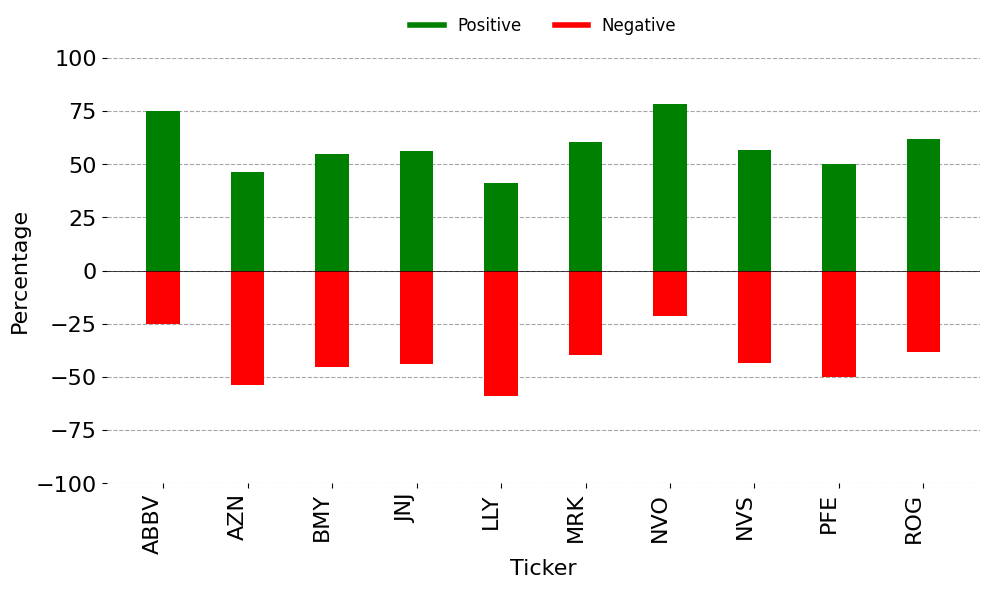

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Group the data by 'symbol_y' column
grouped = df_MODEL.groupby('symbol_y')

# Create a figure and axes for subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize the positions for the bars
bar_width = 0.4
bar_positions = [pos - bar_width/2 for pos in range(len(grouped))]

# Iterate over each group and generate grouped bar plots
for i, (group_name, group_data) in enumerate(grouped):
    positive_count = (group_data['CAR2'] > 0).sum()
    negative_count = (group_data['CAR2'] < 0).sum() 

    total = positive_count + negative_count
    pos_porc = positive_count*100/total
    neg_porc = negative_count*(-100)/total

    counts = [pos_porc, neg_porc]
    labels = ['Positive', 'Negative']

    # Grouped bar chart for positive and negative counts
    ax.bar(bar_positions[i], counts[0], color='green', width=bar_width, label=labels[0])
    ax.bar(bar_positions[i], counts[1], color='red', width=bar_width, label=labels[1], bottom=0)

# Zero baseline
ax.axhline(0, color='black', linewidth=0.5)

# x and y limits
ax.set_ylim(-100, 100)  # Adjust the y-axis limit based on your data

# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# X ticks
ax.set_xticks(bar_positions)
ax.set_xticklabels([group_name for group_name, _ in grouped], rotation=90, ha='right', fontsize=16)
ax.set_xlabel('Ticker', fontsize=16)
ax.set_ylabel('Percentage', fontsize=16)
ax.tick_params(axis='y', labelsize=16)

# Title
#ax.set_title('Positive vs Negative Counts by Ticker', loc='left', fontsize=16)

# Custom Legend
legend_labels = ['Positive', 'Negative']
custom_legend = [plt.Line2D([0], [0], color='green', lw=4),
                 plt.Line2D([0], [0], color='red', lw=4)]
ax.legend(custom_legend, legend_labels, ncol=2, bbox_to_anchor=(0.5, 1.02), loc='lower center', frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


## Models

+ Function definition

In [53]:
# defining all the functions to run all the models

def OLS_model(X_train, X_test, y_train):
    # Add a constant to the features
    X_train1 = sm.add_constant(X_train)
    X_test1 = sm.add_constant(X_test)

    # Create the linear model and complete the least squares fit
    model = sm.OLS(y_train, X_train1)
    results = model.fit()  # fit the model

    # Make predictions from the model for train and test sets
    test_predictions = results.predict(X_test1)

    return test_predictions



def ML_model(X_train, X_test, y_train):
    SEED = 2000

    # model
    model = XGBRegressor()

    # model parameters
    xgb_params = {'objective': ['reg:squarederror'],
                  'learning_rate': [0.05, 1],
                  'max_depth': range(3, 10),
                  'min_child_weight': range(5, 10),
                  'reg_lambda': [1.5],
                  'seed': [SEED]}

    params = [xgb_params]

    # grid search
    best_model = GridSearchCV(model, params[0], n_jobs=4, cv=5,
                                     scoring='neg_mean_squared_error', verbose=0)
    best_model.fit(X_train, y_train)
    # assign the best parameters to the model
    model.set_params(**best_model.best_params_)

    test_predictions_ML = best_model.predict(X_test)

    # Get feature importance scores
    


    return test_predictions_ML, best_model,
#importance_scores


In [54]:
def build_models(combinations, target, df):
    df = df.dropna()
    models = []
    y = df[target]
    importance_scores_list = []

    XGboost_list = []
    
    for i, combination in enumerate(combinations):
        X = df[combination]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2000)
        
        # Call the respective model functions for each combination
        y_pred_OLS = OLS_model(X_train, X_test, y_train)
        y_pred_ML, XGB_model = ML_model(X_train, X_test, y_train)
        
        # Create a DataFrame for the predictions
        pred_df = pd.DataFrame({'True': y_test['CAR2'], 'OLS': y_pred_OLS,
                                 'ML_model': y_pred_ML})
        
        # Append the DataFrame to the models list
        models.append(pred_df)
        XGboost_list.append(XGB_model)
        
    return models, XGboost_list


+ Model definition

In [55]:
combinations = [
                surprise # Model 1
                ,surprise + technical_features + dummies # Model 2
                ,surprise + topic_features_d # Model 3
                ,surprise + cosine_features # Model 4
                ,surprise + graph_features  # Model 5
                ,surprise + graph_features + cosine_features  # Model 6
                ,surprise + graph_features + cosine_features + topic_features_d  # Model 7
                ,surprise + graph_features + cosine_features + topic_features_d + technical_features  + dummies # Model 8
                ,graph_features + cosine_features + topic_features_d  # Model 9
]

y = df_MODEL[target]

# Call the function to build the models
model_dfs, XGB_trained = build_models(combinations, target, df_MODEL)

model_dict = {f'Model_{i+1}': model_df for i, model_df in enumerate(model_dfs)}

num_models = len(combinations)- 1


## Results - MDA and MSE analysis

### Error Analysis

+ Mean Squared Error

In [56]:
print("Mean Squared Error")
print("")
for key in model_dict.keys():
    for column in ['OLS', 'ML_model']:
        print(f'{key}, {column} - {mean_squared_error(model_dict[key]["True"], model_dict[key][column])}')
    print("----------------------------------------")

Mean Squared Error

Model_1, OLS - 0.0027380272084274763
Model_1, ML_model - 0.002598191717414122
----------------------------------------
Model_2, OLS - 0.0029058866703205646
Model_2, ML_model - 0.002957883829110578
----------------------------------------
Model_3, OLS - 0.0027567410386044773
Model_3, ML_model - 0.0027395484040960336
----------------------------------------
Model_4, OLS - 0.0027012405409926527
Model_4, ML_model - 0.0027179130781347354
----------------------------------------
Model_5, OLS - 0.0027572078069560877
Model_5, ML_model - 0.002510118762421201
----------------------------------------
Model_6, OLS - 0.002701382690732932
Model_6, ML_model - 0.002613812734534138
----------------------------------------
Model_7, OLS - 0.0027142425537421476
Model_7, ML_model - 0.0027128530667464416
----------------------------------------
Model_8, OLS - 0.002873685373795207
Model_8, ML_model - 0.0028258589522338106
----------------------------------------
Model_9, OLS - 0.002712524

In [57]:
#https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac
def mean_absolute_percentage_error(actual, predicted):

    actual = np.array(actual)
    predicted = np.array(predicted)
    
    errors = np.abs((actual - predicted) / actual)
    mape = np.mean(errors) * 100
    
    return mape

print("Mean Absolute Percentage Error")
print("")
for key in model_dict.keys():
    for column in ['OLS', 'ML_model']:
        print(f'{key}, {column} - {mean_absolute_percentage_error(model_dict[key]["True"], model_dict[key][column])}')
    print("----------------------------------------")

Mean Absolute Percentage Error

Model_1, OLS - 192.21725522905328
Model_1, ML_model - 185.4207727681952
----------------------------------------
Model_2, OLS - 207.69373360881676
Model_2, ML_model - 210.24134084449182
----------------------------------------
Model_3, OLS - 180.67165341764198
Model_3, ML_model - 352.6978263488441
----------------------------------------
Model_4, OLS - 170.26031798117117
Model_4, ML_model - 155.3593355742696
----------------------------------------
Model_5, OLS - 192.48048307760158
Model_5, ML_model - 172.35693502231413
----------------------------------------
Model_6, OLS - 177.43963247013957
Model_6, ML_model - 157.82399619663576
----------------------------------------
Model_7, OLS - 155.86358088235025
Model_7, ML_model - 225.9470712185199
----------------------------------------
Model_8, OLS - 235.15643261835174
Model_8, ML_model - 194.06933629532838
----------------------------------------
Model_9, OLS - 150.54951230506134
Model_9, ML_model - 211.56

In [58]:
# function to create a table with the results 
def generate_values_dataframe(model_dict, metric):
    data = []
    for key in model_dict.keys():
        for column in ['OLS', 'ML_model']:
            error = metric(model_dict[key]["True"], model_dict[key][column])
            data.append([key, column, error])
    
    df = pd.DataFrame(data, columns=['key', 'column', 'error'])
    df = df.pivot(index='column', columns='key', values='error')
    df = df.reset_index()
    return df

# function to compute the mean directional accuracy

def mean_directional_accuracy(actual, predicted):
    count = pd.DataFrame()
    count['results'] = np.where(((actual > 0) & (predicted > 0)) | ((actual < 0) & (predicted < 0)), 1, 0)
    mda = count['results'].sum()/len(count)

    return mda



# Generate df
MSE_df = generate_values_dataframe(model_dict, mean_squared_error)
MAPE_df = generate_values_dataframe(model_dict, mean_absolute_percentage_error)

+ Saving Errors to df 

In [59]:
# Define the desired column order
column_order = ['column'] + ['Model_' + str(i) for i in range(1, num_models + 2)]

# Reorder the columns
MSE_df_ = MSE_df.reindex(columns=column_order)

# Set the "Model" column as the index
MSE_df_ = MSE_df_.set_index('column')
# Pivot the DataFrame
MSE_pivot = MSE_df_.T.reset_index()
# Rename the columns
MSE_pivot.columns.name = None
# Set the "index" column name to "Column"
MSE_pivot = MSE_pivot.rename(columns={'key': 'Model','ML_model' : 'XG_Boost'})
# Reset the index
MSE_pivot = MSE_pivot.reset_index(drop=True)
print(MSE_pivot.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
  Model &  XG\_Boost &      OLS \\
\midrule
Model\_1 &  0.002598 & 0.002738 \\
Model\_2 &  0.002958 & 0.002906 \\
Model\_3 &  0.002740 & 0.002757 \\
Model\_4 &  0.002718 & 0.002701 \\
Model\_5 &  0.002510 & 0.002757 \\
Model\_6 &  0.002614 & 0.002701 \\
Model\_7 &  0.002713 & 0.002714 \\
Model\_8 &  0.002826 & 0.002874 \\
Model\_9 &  0.002610 & 0.002713 \\
\bottomrule
\end{tabular}



In [60]:
# Define the desired column order
#column_order = ['column'] + ['Model_' + str(i) for i in range(1, 12)]

# Reorder the columns
MAPE_df_ = MAPE_df.reindex(columns=column_order)
# Set the "Model" column as the index
MAPE_df_ = MAPE_df_.set_index('column')
# Pivot the DataFrame
MAPE_pivot = MAPE_df_.T.reset_index()
# Rename the columns
MAPE_pivot.columns.name = None
# Set the "index" column name to "Column"
MAPE_pivot = MAPE_pivot.rename(columns={'key': 'Model','ML_model' : 'XG_Boost' })
# Reset the index
MAPE_pivot = MAPE_pivot.reset_index(drop=True)
print(MAPE_pivot.to_latex(index=False))



\begin{tabular}{lrr}
\toprule
  Model &   XG\_Boost &        OLS \\
\midrule
Model\_1 & 185.420773 & 192.217255 \\
Model\_2 & 210.241341 & 207.693734 \\
Model\_3 & 352.697826 & 180.671653 \\
Model\_4 & 155.359336 & 170.260318 \\
Model\_5 & 172.356935 & 192.480483 \\
Model\_6 & 157.823996 & 177.439632 \\
Model\_7 & 225.947071 & 155.863581 \\
Model\_8 & 194.069336 & 235.156433 \\
Model\_9 & 211.568086 & 150.549512 \\
\bottomrule
\end{tabular}



In [61]:
models_performance = pd.merge(MSE_pivot,MAPE_pivot, left_on=['Model'], right_on=['Model'])
models_performance = models_performance.round(5)
print(models_performance.to_latex(index=False))


\begin{tabular}{lrrrr}
\toprule
  Model &  XG\_Boost\_x &   OLS\_x &  XG\_Boost\_y &     OLS\_y \\
\midrule
Model\_1 &     0.00260 & 0.00274 &   185.42077 & 192.21726 \\
Model\_2 &     0.00296 & 0.00291 &   210.24134 & 207.69373 \\
Model\_3 &     0.00274 & 0.00276 &   352.69783 & 180.67165 \\
Model\_4 &     0.00272 & 0.00270 &   155.35934 & 170.26032 \\
Model\_5 &     0.00251 & 0.00276 &   172.35694 & 192.48048 \\
Model\_6 &     0.00261 & 0.00270 &   157.82400 & 177.43963 \\
Model\_7 &     0.00271 & 0.00271 &   225.94707 & 155.86358 \\
Model\_8 &     0.00283 & 0.00287 &   194.06934 & 235.15643 \\
Model\_9 &     0.00261 & 0.00271 &   211.56809 & 150.54951 \\
\bottomrule
\end{tabular}



### MSE by company

In [62]:
# Merge df to fin the ticker

df_ticker_mse_0 = model_dict['Model_4'].filter(['True','ML_model'])
df_model = df_MODEL.copy()
df_model_ticker = df_model.filter(["symbol"])
df_ticker_mse = pd.merge(df_ticker_mse_0,df_model_ticker, left_on= df_ticker_mse_0.index, right_on=df_model_ticker.index)

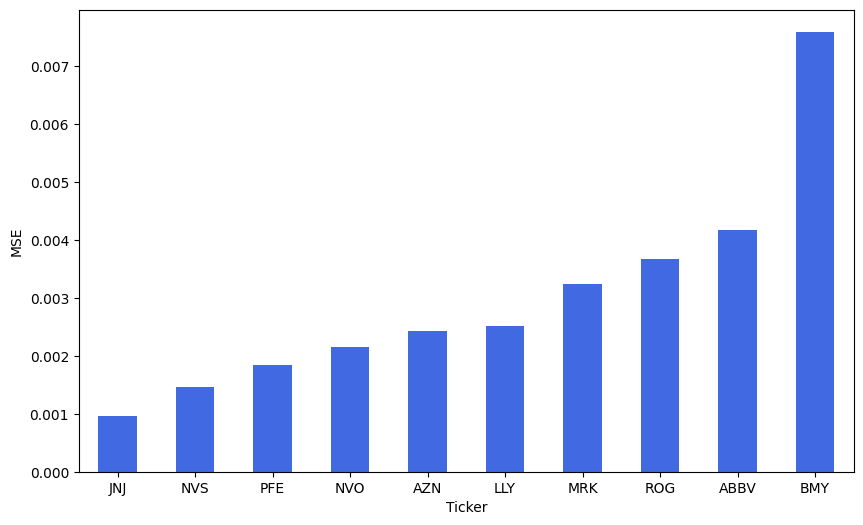

In [63]:
mse_by_company = df_ticker_mse.groupby('symbol').apply(lambda x: mean_squared_error(x['True'], x['ML_model']))
mse_by_company = mse_by_company.sort_values()

plt.figure(figsize=(10, 6))
mse_by_company.plot(kind='bar',color = 'royalblue')
plt.xlabel('Ticker')
plt.ylabel('MSE')
#plt.title('Mean Squared Error by Ticker')
plt.xticks(rotation=0)
plt.show()

## Model explanability

In [64]:
best_model = XGB_trained[4]

#### Feature importance and explanations

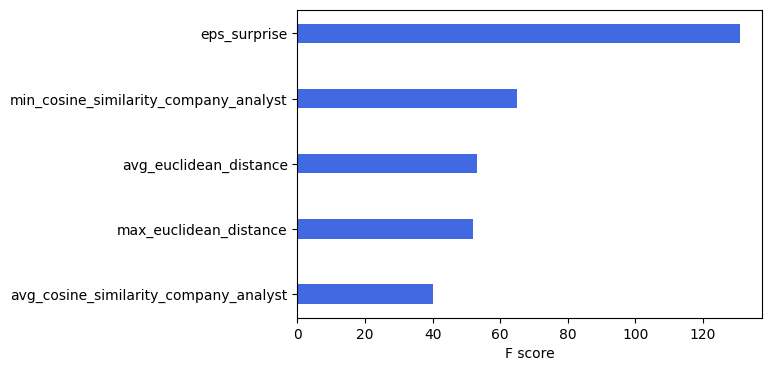

In [65]:
importance_scores = best_model.best_estimator_.get_booster().get_score()

# Get the feature names and importance values
feature_names = list(importance_scores.keys())
importance_values = list(importance_scores.values())

# Set the size of the figure and the spacing between bars
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figsize to change the size of the grid
bar_height = 0.3  # Adjust bar_height to change the spacing between bars

# Sort the importance values and feature names in descending order
sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)
sorted_importance_values = [importance_values[i] for i in sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create a horizontal bar plot
ax.barh(sorted_feature_names, sorted_importance_values, height=bar_height,color = 'royalblue')
ax.set_xlabel('F score')
# ax.set_ylabel('Feature')
# ax.set_title('Feature Importance')
ax.invert_yaxis()  # Invert the y-axis to display features from top to bottom

plt.show()


+ SHAP value

In [66]:
# load JS visualization code to notebook
shap.initjs()

In [67]:
## SHAP values
X = df_MODEL[combinations[4]]
y = df_MODEL[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2000)

# Using a random sample of the dataframe for better time computation
X_sampled = X_train.sample(100, random_state=10)
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(best_model.best_estimator_)

shap_values = explainer.shap_values(X_sampled)
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

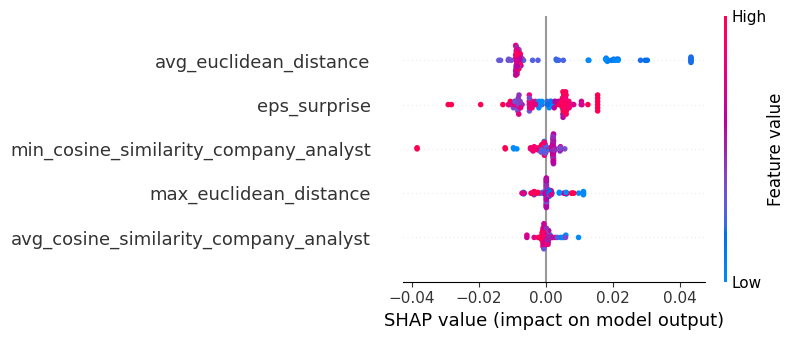

In [68]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

+ Lime

In [69]:
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

In [70]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_array, feature_names=X_train.columns, class_names=['CAR2'], 
                                                verbose=True, mode='regression')



In [71]:
  # Selecting random NVS observation 

observation = X_test.iloc[72]  
print(observation)
print(y_test.iloc[72])


eps_surprise                            -0.135959
avg_cosine_similarity_company_analyst    0.591756
avg_euclidean_distance                   0.850522
min_cosine_similarity_company_analyst    0.533400
max_euclidean_distance                   0.908942
Name: 373, dtype: float64
CAR2   -0.048687
Name: 373, dtype: float64


Intercept 0.007747217190408326
Prediction_local [0.01227694]
Right: 0.014657613


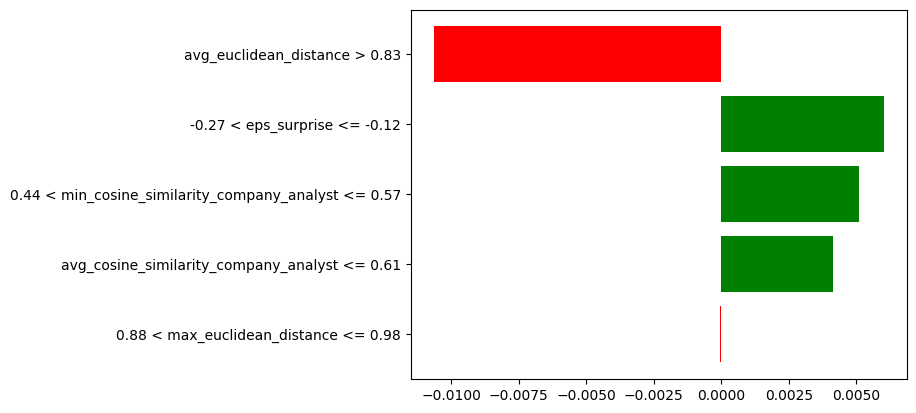

In [72]:
exp = explainer.explain_instance(observation, XGB_trained[4].best_estimator_.predict, num_features=5)

fig = exp.as_pyplot_figure()
ax = fig.gca()
ax.set_title("")  # Set an empty title

plt.show()